In [14]:
import matplotlib.pyplot as plt
from matplotlib_sankey._utils import _clean_axis, _generate_cmap
from matplotlib_sankey._types import CurveType, AcceptedColors
from matplotlib_sankey._patches import patch_curve4, patch_line, patch_curve3
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.path import Path
import numpy as np

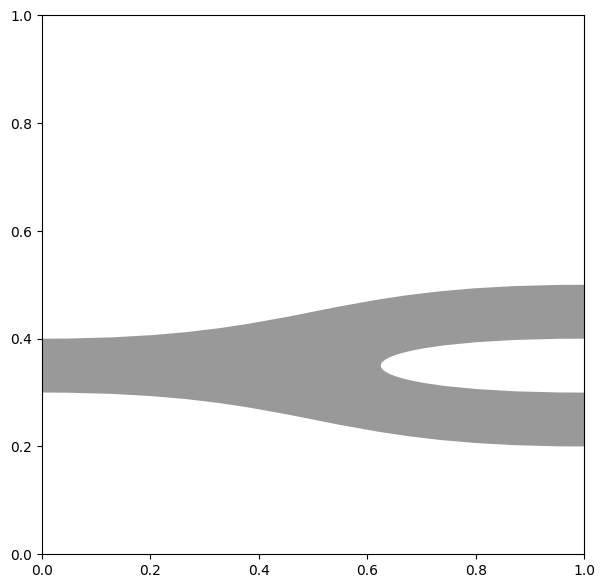

In [15]:
fig, ax = plt.subplots(figsize=(7, 7))
# _clean_axis(ax)


path_patch_kwargs = {
    "color": "black",
    "zorder": 0,
    "alpha": 0.4,
    "lw": 0,
}

y1_start = 0.3
y1_end = 0.2

y2_start = 0.5
y2_end = 0.4


poly = PathPatch(
    Path(
        vertices=[
            # Left lower
            (0.0, y1_start),
            (0.5, y1_start),
            (0.5, y1_end),
            (1, y1_end),
            # Right lower
            # Ident
            (1, y1_end + 0.1),
            # (0.5, (y2_start - y1_end) / 2 + y1_end),
            # (0.5, (y2_start - y1_end) / 2 + y1_end),
            (0.5, y1_end + 0.1),
            (0.5, y2_start - 0.1),
            (1, y2_start - 0.1),
            # Right upper
            (1, y2_start),
            (0.5, y2_start),
            (0.5, y2_end),
            (0, y2_end),
            # left upper
        ],
        codes=[
            Path.MOVETO,
            Path.CURVE4,
            Path.CURVE4,
            Path.CURVE4,
            Path.LINETO,
            Path.CURVE4,
            Path.CURVE4,
            Path.CURVE4,
            Path.LINETO,
            Path.CURVE4,
            Path.CURVE4,
            Path.CURVE4,
        ],
        closed=True,
    ),
    **path_patch_kwargs,
)
ax.add_patch(poly)

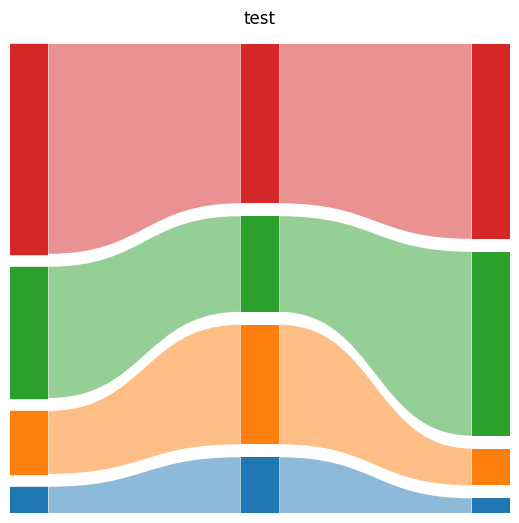

In [16]:
def sankey_simple(
    data: np.ndarray,
    colors: AcceptedColors = "tab10",
    spacing: float = 0.0,
    frameon: bool = True,
    figsize: tuple[int, int] = (5, 5),
    curve_type: CurveType = "curve4",
    alpha: float = 0.5,
    tight_layout: bool = True,
    max_scale: bool = False,
    title: str | None = None,
    column_width: int = 1,
    ribbon_width: int = 12,
) -> Figure:
    """Plot sankey.

    Args:
        data (numpy.ndarray): Input data.
        colors (Union[NDArray, List[str]]): List of colors. Defaults to `tab10`.
        spacing (float, optional): Spacing between column and ribbon patches. Defaults to `0.0`.
        frameon (bool, optional): Draw frame. Defaults to `True`.
        figsize (Tuple[int, int]): Size of figure. Defaults to `(5, 5)`.
        curve_type (Literal["curve3", "curve4", "line"], optional): Curve type ofo ribbon. Defaults to `"curve4"`.
        alpha (float, optional): Alpha of ribbons. Defaults to `0.5`.
        tight_layout (bool, optional): Use tight layout for figure. Defaults to `False`.
        max_scale (bool, optional): Scale values for overall maximum keep absolute differences in column height. Defaults to `False`.
        title (Optional[str], optional): Title of figure. Defaults to `None`.
        column_width (int, optional): Relative width of columns. Defaults to `1`.
        ribbon_width (int, optional): Relative width of ribbons. Defaults to `12`.

    """
    ncols, nrows = data.shape

    # Get cmap
    cmap = _generate_cmap(value=colors, nrows=nrows)

    # Max Scale data to 1
    scaled_data: np.ndarray[np.float64] = np.zeros(data.shape)
    scale_factor: np.ndarray[np.float64]

    if max_scale is True:
        scale_factor = np.array([data.sum(axis=1).max()] * ncols)
    else:
        scale_factor = data.sum(axis=1)

    for index, data_colum in enumerate(data):
        scaled_data[index] = data_colum / scale_factor[index]

    assert scaled_data.shape == data.shape, f"Scaled shape {scaled_data.shape} does not match input data {data.shape}"

    # Init figure and axes
    axes: list[Axes]

    fig, axes = plt.subplots(
        nrows=1,
        ncols=ncols + ncols - 1,
        sharey=True,
        width_ratios=[*([column_width, ribbon_width] * (ncols - 1)), column_width],
        frameon=frameon,
        figsize=figsize,
    )

    # Remove spacing
    fig.subplots_adjust(hspace=0, wspace=0)

    total_height = 1.0 + (nrows * spacing)

    # Draw columns on first axes
    axes[0] = _clean_axis(axes[0], frameon=False)
    axes[0].set_ylim(0.0, total_height)

    for index, size in enumerate(scaled_data[0]):
        rect = Rectangle(
            xy=(0, sum(scaled_data[0][:index]) + (index * spacing)), width=1, height=size, color=cmap(index), zorder=1
        )
        axes[0].add_patch(rect)

    for count_index, column_index in enumerate(((np.arange(ncols - 1) + 1) * 2) - 1):
        # Draw ribbons
        axes[column_index] = _clean_axis(axes[column_index], frameon=False)
        axes[column_index].set_ylim(0.0, total_height)

        for index in range(nrows):
            y1_start = sum(scaled_data[count_index][:index])
            y1_end = sum(scaled_data[count_index + 1][:index])

            y2_start = sum(scaled_data[count_index + 1][: index + 1])
            y2_end = sum(scaled_data[count_index][: index + 1])

            poly: PathPatch

            # Add curves
            if curve_type == "curve4":
                poly = patch_curve4(
                    x_start=0,
                    x_end=1,
                    y1_start=y1_start,
                    y1_end=y1_end,
                    y2_start=y2_start,
                    y2_end=y2_end,
                    row_index=index,
                    spacing=spacing,
                    alpha=alpha,
                    color=cmap(index),
                )

            elif curve_type == "line":
                poly = patch_line(
                    x_start=0,
                    x_end=1,
                    y1_start=y1_start,
                    y1_end=y1_end,
                    y2_start=y2_start,
                    y2_end=y2_end,
                    row_index=index,
                    spacing=spacing,
                    alpha=alpha,
                    color=cmap(index),
                )

            elif curve_type == "curve3":
                poly = patch_curve3(
                    x_start=0,
                    x_end=1,
                    y1_start=y1_start,
                    y1_end=y1_end,
                    y2_start=y2_start,
                    y2_end=y2_end,
                    row_index=index,
                    spacing=spacing,
                    alpha=alpha,
                    color=cmap(index),
                )
            else:
                raise ValueError(f"curve_type '{curve_type}' not supported.")

            axes[column_index].add_patch(poly)

        # Add column for last data item
        axes[column_index + 1] = _clean_axis(axes[column_index + 1], frameon=False)
        axes[column_index + 1].set_ylim(0.0, total_height)

        for index, size in enumerate(scaled_data[count_index + 1]):
            rect = Rectangle(
                xy=(0, sum(scaled_data[count_index + 1][:index]) + (index * spacing)),
                width=1,
                height=size,
                color=cmap(index),
                zorder=1,
                lw=0,
            )
            axes[column_index + 1].add_patch(rect)

    if title is not None:
        fig.suptitle(title, horizontalalignment="center", verticalalignment="baseline")

    if tight_layout is True:
        fig.tight_layout(pad=0)

    plt.close()
    return fig


data = np.array([[10, 24, 50, 80], [14, 30, 24, 40], [4, 10, 50, 53]])

sankey_simple(
    data,
    spacing=0.03,
    ribbon_width=5,
    column_width=1,
    title="test",
    # show_legend=True,
    # legend_labels=[
    #     "1",
    #     "2",
    #     "3",
    #     "4",
    # ],
    # column_labels=[
    #     "A",
    #     "B",
    #     "C",
    # ],
)

<Axes: title={'center': 'test'}>

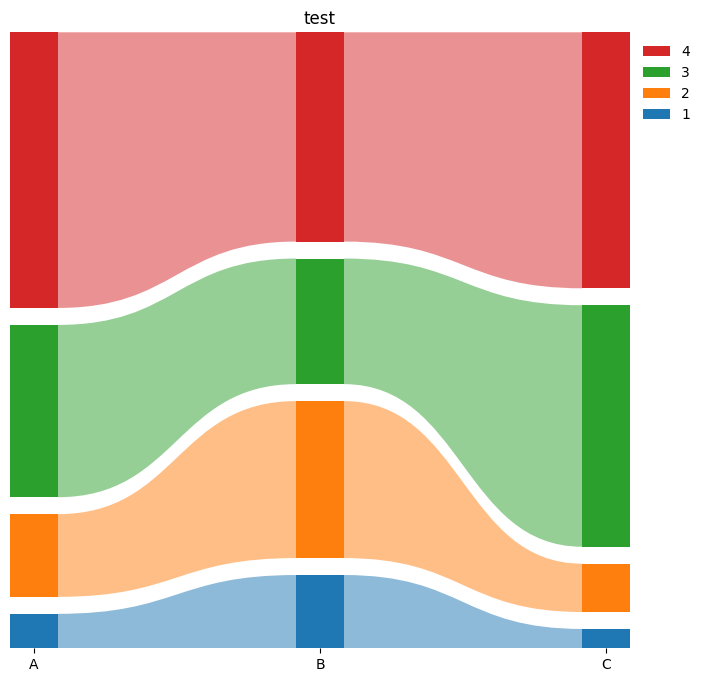

In [19]:
from matplotlib.ticker import FixedLocator
from matplotlib.patches import Patch


def sankey_simple2(
    data: np.ndarray,
    colors: AcceptedColors = "tab10",
    spacing: float = 0.0,
    frameon: bool = True,
    figsize: tuple[int, int] = (5, 5),
    curve_type: CurveType = "curve4",
    alpha: float = 0.5,
    max_scale: bool = False,
    title: str | None = None,
    column_width: int = 1,
    ribbon_width: int = 12,
    show: bool = True,
    ax: Axes | None = None,
    column_labels: list[str] | None = None,
    show_legend: bool = False,
    legend_labels: list[str] | None = None,
) -> Axes:
    """Plot sankey.

    Args:
        data (numpy.ndarray): Input data.
        colors (Union[NDArray, List[str]]): List of colors. Defaults to `tab10`.
        spacing (float, optional): Spacing between column and ribbon patches. Defaults to `0.0`.
        frameon (bool, optional): Draw frame. Defaults to `True`.
        figsize (Tuple[int, int]): Size of figure. Defaults to `(5, 5)`.
        curve_type (Literal["curve3", "curve4", "line"], optional): Curve type ofo ribbon. Defaults to `"curve4"`.
        alpha (float, optional): Alpha of ribbons. Defaults to `0.5`.
        max_scale (bool, optional): Scale values for overall maximum keep absolute differences in column height. Defaults to `False`.
        title (Optional[str], optional): Title of figure. Defaults to `None`.
        column_width (int, optional): Relative width of columns. Defaults to `1`.
        ribbon_width (int, optional): Relative width of ribbons. Defaults to `12`.
        show (bool, optional): Show figure. Defaults to `True`.
        ax (matplotlib.Axes | None, optional): Provide matplotlib Axes instance for plotting. Defaults to `None`.
        column_labels  (list[str] | None, optional): Column labels to display as x axis tick labels. Defaults to `None`.
        show_legend (bool, optional): Show legend. Defaults to `False`. If legend should be displayed, also provide `legend_labels`.
        legend_labels: (list[str] | None, optional): Labels to display in legend. Defaults to `None`.

    Returns:
        Matplotlib axes instance.

    ReturnType:
        matplitlib.Axes

    """
    ncols, nrows = data.shape

    rel_column_width = column_width / (column_width + ribbon_width)
    # rel_ribbon_width = ribbon_width / (column_width + ribbon_width)

    # Get cmap
    cmap = _generate_cmap(value=colors, nrows=nrows)

    # Max Scale data to 1
    scaled_data: np.ndarray[np.float64] = np.zeros(data.shape)
    scale_factor: np.ndarray[np.float64]

    if max_scale is True:
        scale_factor = np.array([data.sum(axis=1).max()] * ncols)
    else:
        scale_factor = data.sum(axis=1)

    for index, data_colum in enumerate(data):
        scaled_data[index] = data_colum / scale_factor[index]

    assert scaled_data.shape == data.shape, f"Scaled shape {scaled_data.shape} does not match input data {data.shape}"

    # fig: Figure

    # Init figure and axes
    if ax is None:
        _, ax = plt.subplots(
            frameon=frameon,
            figsize=figsize,
        )
    # else:
    #     fig = plt.gcf()

    ax.xaxis.set_major_locator(FixedLocator(list(range(ncols))))

    total_height = 1.0 + (nrows * spacing) - spacing

    # Draw columns on first axes
    ax = _clean_axis(ax, frameon=False, reset_x_ticks=column_labels is None)
    ax.set_ylim(0.0, total_height)
    ax.set_xlim(-1 * (rel_column_width / 2), (ncols - 1) + (rel_column_width / 2))

    for column_index in range(ncols):
        for index, size in enumerate(scaled_data[column_index]):
            rect = Rectangle(
                xy=(column_index - (rel_column_width / 2), sum(scaled_data[column_index][:index]) + (index * spacing)),
                width=rel_column_width,
                height=size,
                color=cmap(index),
                zorder=1,
                lw=0,
            )
            ax.add_patch(rect)

    if show_legend is True:
        assert legend_labels is not None
        assert len(legend_labels) == nrows
        legend_patches = []
        for rect_index in range(nrows):
            legend_patches.append(Patch(facecolor=cmap(rect_index), label=legend_labels[rect_index]))
        ax.legend(
            handles=legend_patches[::-1],
            frameon=False,
            bbox_to_anchor=(1, 1),
            loc="upper left",
        )

    for column_index in range(ncols - 1):
        for index in range(nrows):
            y1_start = sum(scaled_data[column_index][:index])
            y1_end = sum(scaled_data[column_index + 1][:index])

            y2_start = sum(scaled_data[column_index + 1][: index + 1])
            y2_end = sum(scaled_data[column_index][: index + 1])

            poly: PathPatch

            # Add curves
            if curve_type == "curve4":
                poly = patch_curve4(
                    x_start=column_index + (rel_column_width / 2),
                    x_end=column_index + 1 - (rel_column_width / 2),
                    y1_start=y1_start,
                    y1_end=y1_end,
                    y2_start=y2_start,
                    y2_end=y2_end,
                    row_index=index,
                    spacing=spacing,
                    alpha=alpha,
                    color=cmap(index),
                )

            elif curve_type == "line":
                poly = patch_line(
                    x_start=column_index + (rel_column_width / 2),
                    x_end=column_index + 1 - (rel_column_width / 2),
                    y1_start=y1_start,
                    y1_end=y1_end,
                    y2_start=y2_start,
                    y2_end=y2_end,
                    row_index=index,
                    spacing=spacing,
                    alpha=alpha,
                    color=cmap(index),
                )

            elif curve_type == "curve3":
                poly = patch_curve3(
                    x_start=column_index + (rel_column_width / 2),
                    x_end=column_index + 1 - (rel_column_width / 2),
                    y1_start=y1_start,
                    y1_end=y1_end,
                    y2_start=y2_start,
                    y2_end=y2_end,
                    row_index=index,
                    spacing=spacing,
                    alpha=alpha,
                    color=cmap(index),
                )
            else:
                raise ValueError(f"curve_type '{curve_type}' not supported.")

            ax.add_patch(poly)

    if title is not None:
        ax.set_title(title, horizontalalignment="center", verticalalignment="baseline")

    if column_labels is not None:
        assert len(column_labels) == ncols
        ax.set_xticklabels(column_labels)

    if show is False:
        plt.close()
    return ax


data = np.array([[10, 24, 50, 80], [14, 30, 24, 40], [4, 10, 50, 53]])

fig, ax = plt.subplots(figsize=(8, 8))
sankey_simple2(
    data,
    spacing=0.03,
    ax=ax,
    ribbon_width=5,
    column_width=1,
    title="test",
    show_legend=True,
    legend_labels=[
        "1",
        "2",
        "3",
        "4",
    ],
    column_labels=[
        "A",
        "B",
        "C",
    ],
)